# Conspiracy Theory Election Notebook




Exploration of Election Twitter dataset

## Importing Data

In [1]:
import pandas as pd
import numpy as np
import json
import jsonlines
import os
from os import path
from PIL import Image
from tqdm.auto import tqdm as tqdm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from os import listdir
from os.path import isfile, join
from collections import Counter
from nltk import ngrams
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast
import warnings
warnings.filterwarnings("ignore")

### Sampling to reduce dataset size

Not required if using preprocessed data

In [2]:
homepath = '../../'
election_path = homepath + 'election_data/'

In [3]:
# Files downloaded from Emily's dataset
months = ['2020-06/','2020-07/','2020-08/','2020-09/']

In [4]:
# List the csv files in the directories
csv_files = []
filepath = election_path + 'election_csvs/'
files = []
files = [f for f in os.listdir(filepath) if not f.startswith('.')]
for month in months:
    csv_files  += [filepath+month + f for f in listdir(filepath+month) if isfile(join(filepath+month, f)) and not f.startswith('.') and f[-3:] == 'csv']
csv_files = sorted(csv_files)
len(csv_files)

1886

In [5]:
# Timestamps of the csvs
csv_timestamps  = []
for i in range(len(csv_files)):
    csv_timestamps.append(pd.Timestamp(csv_files[i][-23:-18]+csv_files[i][-12:-4]))

In [104]:
# Sampling 

dates = []
hours = []
sample_every = 50

print('No. files:', len(csv_timestamps[::sample_every]))
sample_files =  csv_files[::sample_every]

for i in range(len(csv_timestamps[::sample_every])):
    dates.append(csv_timestamps[::sample_every][i].day)
    hours.append(csv_timestamps[::sample_every][i].hour)

No. files: 38


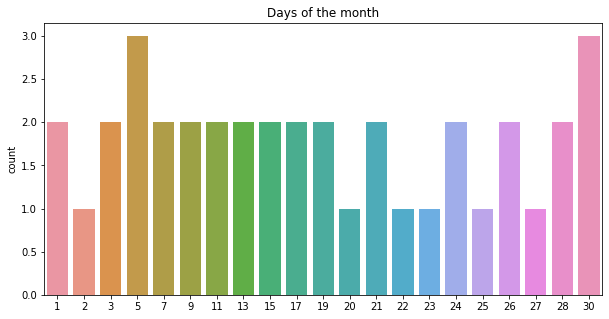

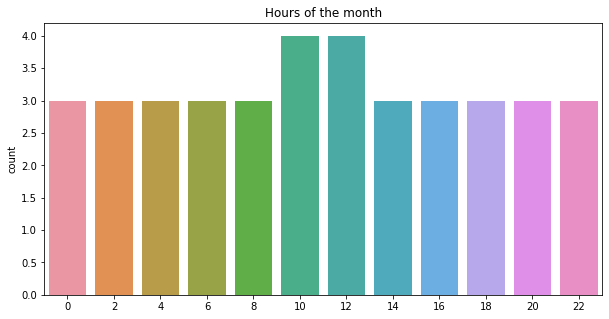

In [105]:
# Make sure the samples have an even number of days in the month and the hours
plt.figure(figsize = (10,5))
plt.title('Days of the month')
sns.countplot(dates)
plt.show()

plt.figure(figsize = (10,5))
plt.title('Hours of the month')
sns.countplot(hours)
plt.show()

In [108]:
# # Get sampled dfs for general corona tweets
control_df = pd.DataFrame()

# Get only conspiracy and url with news chanel related tweets
col_list = ['tweetid', 'userid', 'screen_name', 'date', 'lang', 'location', 'text',
            'tweet_type', 'followers_count','favourites_count', 'verified', 'hashtag', 
            'mentionid','mentionsn','rt_userid','rt_screen','rt_rt_count','rt_fav_count',
            'rt_tweetid','urls_list','account_creation_date']

for i,file in tqdm(enumerate(sample_files)):
    control_df = control_df.append(pd.read_csv(file,usecols=col_list))
control_df.shape

(4787782, 21)

In [10]:
# Get random names from control df

# import random
# len(control_df.screen_name.unique())
# rands = random.choices(control_df.screen_name.unique(), k= 5000)
# rands = [i.lower() for i in rands]
# control_names = pd.DataFrame(rands, columns=['names'])
# control_names.to_csv('Botometer_to_query/control_election_names.csv',index=False)

# Conspiracy theory analysis

In [11]:
def create_cloud(string,exclude = None):
    wordcloud = WordCloud(width=800,height=400,max_font_size=50, max_words=100,
                      collocations=False, background_color="white", stopwords = exclude
                     ).generate(string)

    # Display the generated image:
    plt.figure(figsize = (20,20))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [12]:
# Find hashtags for tweets
def hash_tweets(string,df):
    tweets = df[df.hashtag.str.contains(string)]
    return tweets

In [13]:
# Find text for tweets
def text_tweets(string,df):
    tweets = df[df.text.str.contains(string)]
    return tweets

In [14]:
# Find urls for tweets
def url_tweets(string,df):
    tweets = df[df.urls_list.str.contains(string)]
    return tweets

In [119]:
# Get tweets, create a cloud, get users associated with each url substring
def get_hashtags_tweets(df,hashtag_list,cloud=True):
    users = set()
    hash_dict = {}
    hash_df = pd.DataFrame()

    for hashtag in hashtag_list:
        these_hashtags = hash_tweets(hashtag,df)
        hash_df = hash_df.append(these_hashtags)
        hash_dict[hashtag] = these_hashtags.screen_name.unique()
        these_users = list(these_hashtags.screen_name.unique())
        users.update(these_users)
        if cloud:
            related_hashs = ' '.join(these_hashtags.hashtag)
            try:
                create_cloud(related_hashs,exclude = [hashtag])
            except:
                pass
            
        print('\n%s num tweets: %d' % (hashtag, len(hash_df)))
        print('%s unique users: %d' %(hashtag, len(these_users)))
    
    return list(users), hash_dict, hash_df

In [16]:
# Get tweets, create a cloud, get users associated with each url substring
def get_url_usertweets(df,url_list):
    users = set()
    url_dict = {}
    url_df = pd.DataFrame()

    for url in url_list:
        these_urls = url_tweets(url,df)
        url_df = url_df.append(these_urls)
        url_dict[url] = these_urls.screen_name.unique()
        users.update(list(these_urls.screen_name.unique()))
    
    return list(users), url_dict, url_df

In [17]:
# Get tweets, create a cloud, get users associated with each url substring
def get_text_tweets(df,text_list):
    users = []
    text_dict = {}
    text_df = pd.DataFrame()

    for text in text_list:
        these_keyword = text_tweets(text,df)
        text_df = text_df.append(these_keyword)
        text_dict[text] = these_keyword.screen_name.unique()
        users += list(these_keyword.screen_name.unique())
    
    return users, text_dict, text_df

In [18]:
def unique(list1): 
    x = np.array(list1) 
    return np.unique(x)

In [19]:
""" 
Tweet Columns
       'tweetid', 'userid', 'screen_name', 'date', 'lang', 'location',
       'place_id', 'place_url', 'place_type', 'place_name', 'place_full_name',
       'place_country_code', 'place_country', 'place_bounding_box', 'text',
       'extended', 'coord', 'reply_userid', 'reply_screen', 'reply_statusid',
       'tweet_type', 'friends_count', 'listed_count', 'followers_count',
       'favourites_count', 'statuses_count', 'verified', 'hashtag',
       'urls_list', 'profile_pic_url', 'profile_banner_url', 'display_name',
       'date_first_tweet', 'account_creation_date', 'rt_urls_list',
       'mentionid', 'mentionsn', 'rt_screen', 'rt_userid', 'rt_text',
       'rt_hashtag', 'rt_qtd_count', 'rt_rt_count', 'rt_reply_count',
       'rt_fav_count', 'rt_tweetid', 'qtd_screen', 'qtd_userid', 'qtd_text',
       'qtd_hashtag', 'qtd_qtd_count', 'qtd_rt_count', 'qtd_reply_count',
       'qtd_fav_count', 'qtd_tweetid', 'qtd_urls_list'                         
"""

# rt_screen is who is being retweeted

" \nTweet Columns\n       'tweetid', 'userid', 'screen_name', 'date', 'lang', 'location',\n       'place_id', 'place_url', 'place_type', 'place_name', 'place_full_name',\n       'place_country_code', 'place_country', 'place_bounding_box', 'text',\n       'extended', 'coord', 'reply_userid', 'reply_screen', 'reply_statusid',\n       'tweet_type', 'friends_count', 'listed_count', 'followers_count',\n       'favourites_count', 'statuses_count', 'verified', 'hashtag',\n       'urls_list', 'profile_pic_url', 'profile_banner_url', 'display_name',\n       'date_first_tweet', 'account_creation_date', 'rt_urls_list',\n       'mentionid', 'mentionsn', 'rt_screen', 'rt_userid', 'rt_text',\n       'rt_hashtag', 'rt_qtd_count', 'rt_rt_count', 'rt_reply_count',\n       'rt_fav_count', 'rt_tweetid', 'qtd_screen', 'qtd_userid', 'qtd_text',\n       'qtd_hashtag', 'qtd_qtd_count', 'qtd_rt_count', 'qtd_reply_count',\n       'qtd_fav_count', 'qtd_tweetid', 'qtd_urls_list'                         \n"

In [20]:
# Conspiracy theory hashtags
qanon_keywords = ['qanon',
                  'greatawakening',
                  'wwg1wga',
                  'qarmy'
                 ]


pizza_keywords = ['pizzagate'
                 ]

all_keywords = list(set(qanon_keywords+pizza_keywords))

In [21]:
# News url substrings to look for in tweet url lists (Try sampling)

news_sources = ['msnbc',
                'nydailynews',
                'reuters',
                'foxnews',
                'cnn',
                'wsj',
                'huffpost',
                'nyt',
                'dailymail',
                'washingtonpost',
                'theguardian',
                'abcnews',
                'bbc',
                'usatoday',
                'infowars',
                'oann',
                'latimes',
                'cnbc',
                'boston',
                'yahoo',
                'chicagotribune',
                'msn',
                'breitbart'
               ]

### Get tweets from preprocessed csvs

Used once the conspiracy theory tweets have been found and saved

In [ ]:
# # Preprocessed csvs with only conspiracy and url tweets
# df1 = pd.read_csv(election_path + 'election_conspiracies_parsed_1.csv')
# df2 = pd.read_csv(election_path + 'election_conspiracies_parsed_2.csv')
# df3 = pd.read_csv(election_path + 'election_conspiracies_parsed_3.csv')

# print(df1.shape)
# print(df2.shape)
# print(df3.shape)
# df = df1.append(df2).append(df3)

In [ ]:
df = pd.read_csv(election_path + 'election_just_conspiracies_parsed.csv')
df.shape

In [ ]:
# df.drop_duplicates(inplace = True)
# df.to_csv(election_path + 'election_conspiracies_parsed_all.csv', index=False)

In [ ]:
df.shape

In [ ]:
qanon_df_h.shape

In [ ]:
# # Separate retweets from non retweets tweets
# orig_df = df[pd.isnull(df['rt_userid'])]
# rt_df = df.dropna(subset=['rt_userid'])

In [ ]:
# Use if all df loaded from csv
# tweet_df = df
tweet_df = df.dropna(subset=['hashtag'])
df = pd.DataFrame()

# Get only conspiracy and url with news chanel related tweets
col_list = ['tweetid', 'userid', 'screen_name', 'date', 'lang', 'location', 'text',
            'tweet_type', 'followers_count','favourites_count', 'verified', 'hashtag', 
            'mentionid','mentionsn','rt_userid','rt_screen','rt_rt_count','rt_fav_count',
            'rt_tweetid','urls_list','account_creation_date']

clouds = False

qanon_users=set()
pizza_users=set()

url_dict = {}

tweet_df.reset_index(drop=True,inplace=True)
tweet_df = tweet_df.apply(lambda x: x.astype(str).str.lower())
tweet_df.replace('nan',np.nan,inplace=True)
tweet_df.hashtag = tweet_df.hashtag.str.replace("'", '')

qanon_users_h, qanon_dict_h, qanon_df_h = get_hashtags_tweets(tweet_df,qanon_keywords,cloud=clouds)
pizza_users_h, pizza_dict_h, pizza_df_h = get_hashtags_tweets(tweet_df,pizza_keywords,cloud=clouds)

tweet_df = tweet_df[tweet_df.urls_list!='[]']

qanon_users.update(qanon_users_h)
pizza_users.update(pizza_users_h)

# Get tweets, create a cloud, get users associated with each news source
url_users, url_dict_temp, news_url_df = get_url_usertweets(tweet_df,news_sources)
for urlkey,urlval in url_dict_temp.items():
    this_set = set(urlval)
    if url_dict.get(urlkey):
        this_set.update(url_dict.get(urlkey))
    url_dict[urlkey]=this_set

df = df.append(qanon_df_h)
df = df.append(pizza_df_h)

df = df.append(news_url_df)

del tweet_df, news_url_df
gc.collect()

In [ ]:
print(qanon_df_h.shape)
print(pizza_df_h.shape)
df.shape

In [ ]:
consp_users = qanon_users
consp_users.update(pizza_users)
consp_name_df = pd.DataFrame(list(consp_users), columns=['names'])
# consp_name_df.to_csv('Botometer_to_query/qanon_pizza_users.csv', index=False)

### Get all tweets from raw tweet files

In [25]:
# Use for processing all tweets from downloaded dataset

# Get only conspiracy and url with news chanel related tweets
col_list = ['tweetid', 'userid', 'screen_name', 'date', 'lang', 'location', 'text',
            'tweet_type', 'followers_count','favourites_count', 'verified', 'hashtag', 
            'mentionid','mentionsn','rt_userid','rt_screen','rt_rt_count','rt_fav_count',
            'rt_tweetid','urls_list','account_creation_date']

df = pd.DataFrame()

clouds=False

qanon_users=set()
pizza_users=set()

url_dict = {}

for i,file in tqdm(enumerate(sample_files)):

    tweet_df = pd.read_csv(file,usecols=col_list)
    tweet_df.reset_index(drop=True,inplace=True)
    tweet_df = tweet_df.apply(lambda x: x.astype(str).str.lower())
    tweet_df.replace('nan',np.nan,inplace=True)
    tweet_df.hashtag = tweet_df.hashtag.str.replace("'", '')

    qanon_users_h, qanon_dict_h, qanon_df__h = get_hashtags_tweets(tweet_df,qanon_keywords,cloud=clouds)
    pizza_users_h, pizza_dict_h, pizza_df__h = get_hashtags_tweets(tweet_df,pizza_keywords,cloud=clouds)
    
#     qanon_df_h = qanon_df_h.append(qanon_df__h)
#     pizza_df_h = pizza_df_h.append(pizza_df__h)
    
#     qanon_users.update(qanon_users_h)
#     pizza_users.update(pizza_users_h)
    
    tweet_df = tweet_df[tweet_df.urls_list!='[]']

    # Get tweets, create a cloud, get users associated with each news source
#     url_users, url_dict_temp, news_url_df = get_url_usertweets(tweet_df,news_sources)
#     for urlkey,urlval in url_dict_temp.items():
#         this_set = set(urlval)
#         if url_dict.get(urlkey):
#             this_set.update(url_dict.get(urlkey))
#         url_dict[urlkey]=this_set

    df = df.append(qanon_df__h)
    df = df.append(pizza_df__h)

#     df = df.append(news_url_df)

    if i % 100 == 0:
        df.to_csv(election_path + 'election_just_conspiracies_parsed.csv', index=False)
    
    del tweet_df#, news_url_df

    gc.collect()
    
df.to_csv(election_path + 'election_just_conspiracies_parsed.csv', index=False)

In [ ]:
# df.to_csv(election_path + 'election_conspiracies_parsed.csv', index=False)

In [26]:
print(df.shape)

(760249, 21)


## Conspiracy theory wordclouds

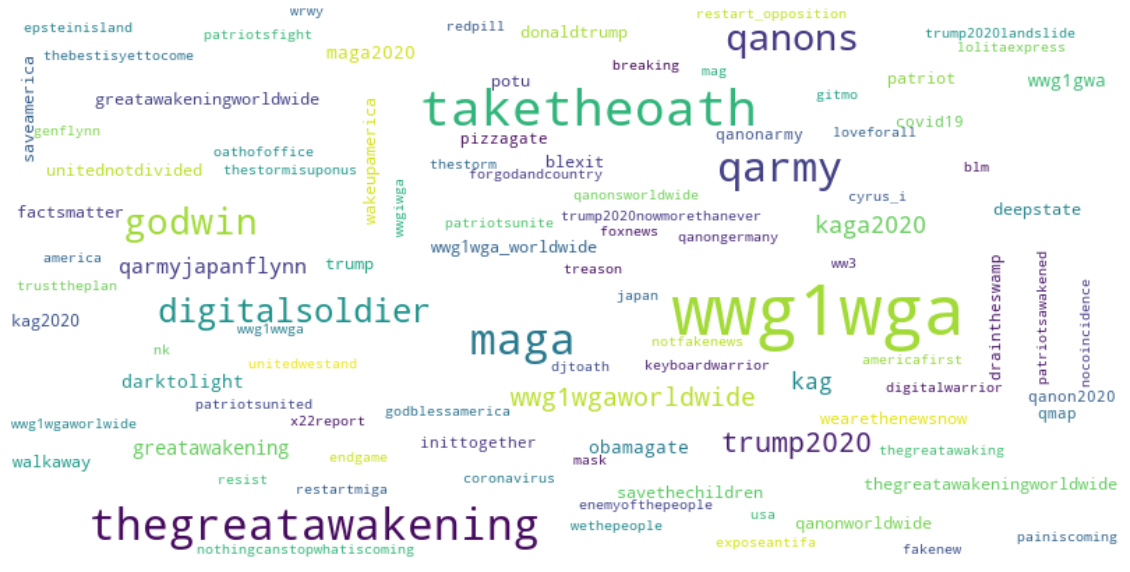

qanon 74217


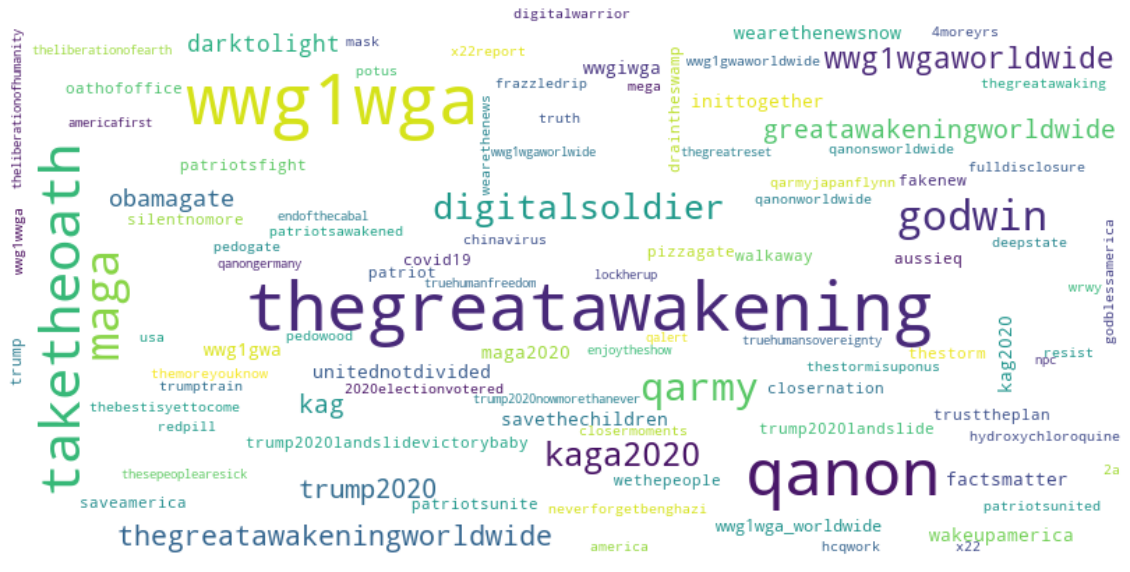

greatawakening 31170


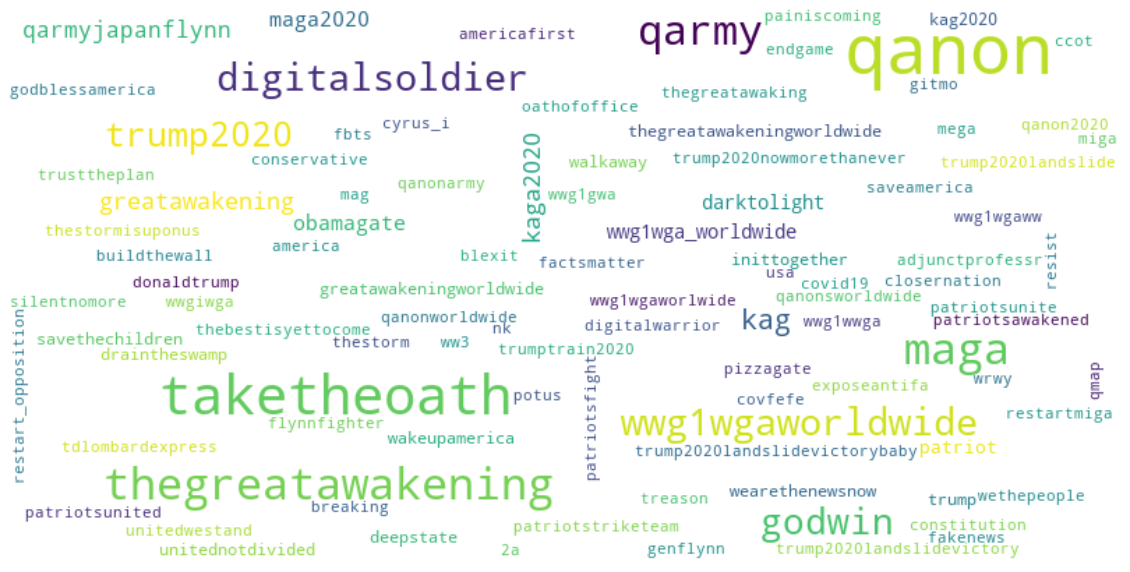

wwg1wga 85334


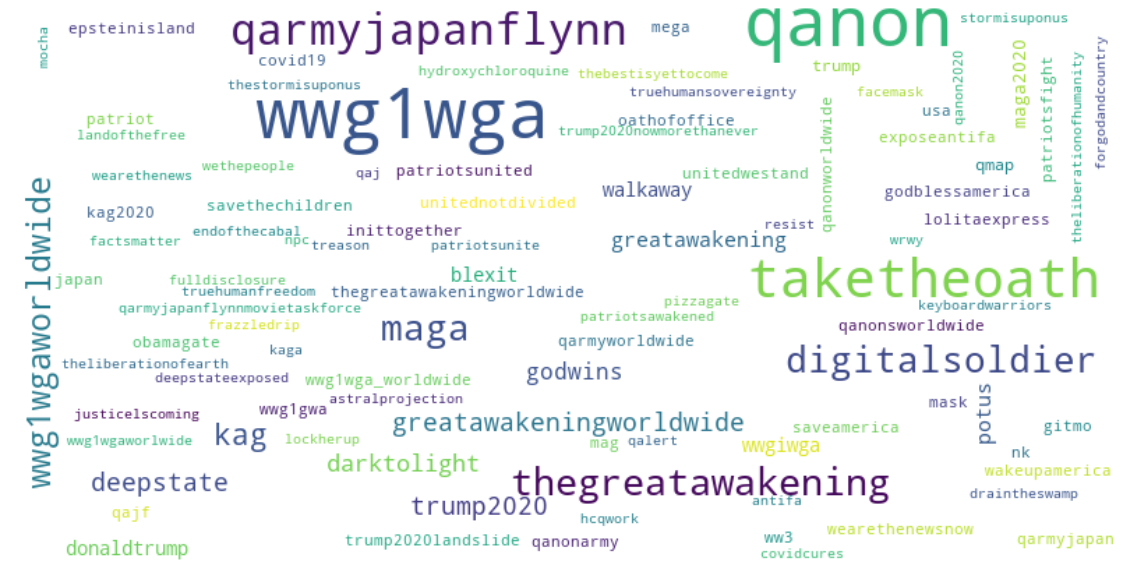

qarmy 17738


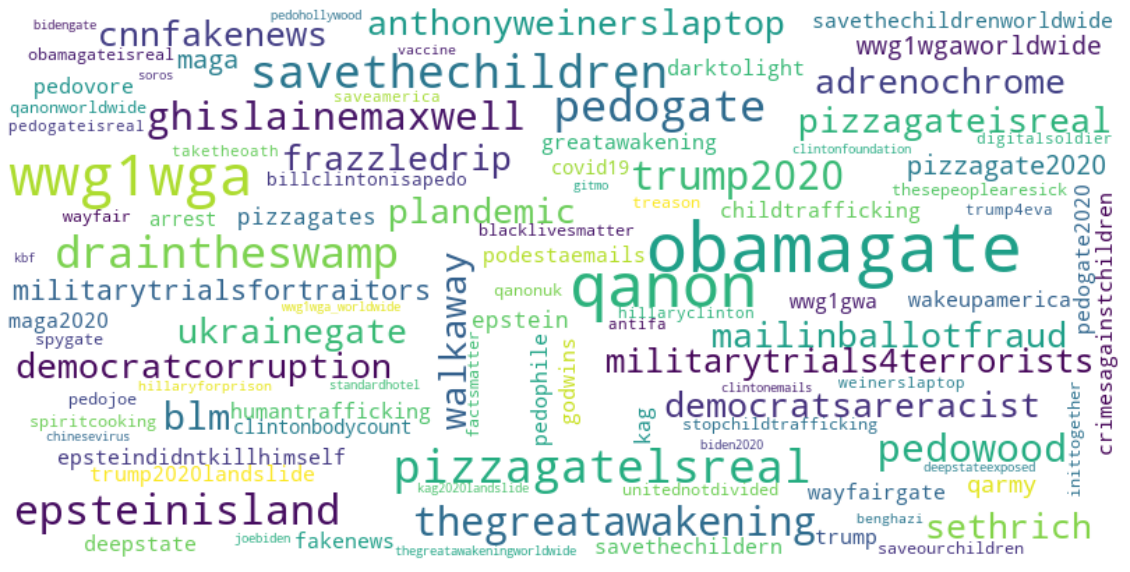

pizzagate 12454


In [31]:
# Get users associated with conspiracy theories and plot wordclouds for related hashtags

clouds=True
# conspiracy_users_h, conspiracy_dict_h, consps_df_h = get_hashtags_tweets(df.dropna(subset=['hashtag']),keywords,cloud=clouds)
qanon_users_h, qanon_dict_h, qanon_df_h = get_hashtags_tweets(df.dropna(subset=['hashtag']),qanon_keywords,cloud=clouds)
pizza_users_h, pizza_dict_h, pizza_df_h = get_hashtags_tweets(df.dropna(subset=['hashtag']),pizza_keywords,cloud=clouds)

In [32]:
all_consp_hashtags_df = pd.concat([qanon_df_h],axis=0)
all_consp_hashtags_df.drop_duplicates(inplace=True)

In [33]:
print('Unique qanon conspiracy tweeters:      ',len(list(set(qanon_users_h))))
print('Unique pizza conspiracy tweeters:      ',len(list(set(pizza_users_h))))

Unique qanon conspiracy tweeters:       119096
Unique pizza conspiracy tweeters:       12454


## Conspiracy keywords in tweet text

Looking at the tweet text instead of hashtags

In [49]:
conspiracy_users, conspiracy_dict, consps_df = get_text_tweets(df,keywords)
qanon_users, qanon_dict, qanon_df = get_text_tweets(df,qanon_keywords)

In [50]:
all_consp_text_df = pd.concat([qanon_df],axis=0)
all_consp_text_df.drop_duplicates(inplace=True)

In [48]:
print('Unique conspiracy tweeters:            ', len(list(set(conspiracy_users))))
print('Unique qanon conspiracy tweeters:      ', len(list(set(qanon_users))))

Unique conspiracy tweeters:             0
Unique qanon conspiracy tweeters:       2556


## News urls and conspiracies

In [53]:
# Urls and number of users
url_keys = url_dict.keys()
url_tots = [len(i) for i in url_dict.values()]

In [54]:
# All tweeters who tweet using conspiracy theory hashtags
all_consp_users = list(set(list(qanon_users)))
len(all_consp_users)

0

In [55]:
# General (non conspiracy) tweeters who use urls from each sources
url_general_users = {}
for key,value in url_dict.items():
    url_general_users[key] = list(set(url_dict[key]).difference(set(all_consp_users)))
    
# Number of general (non conspiracy) tweeters who use urls from each sources
num_url_general = {}
for key,value in url_dict.items():
    num_url_general[key] = len((set(url_dict[key]).difference(set(all_consp_users))))
    
# Number of tweeters who use urls from each sources who tweet conspiracy theories
num_url_consp = {}
for key,value in url_dict.items():
    num_url_consp[key] = len((set(url_dict[key]).intersection(set(all_consp_users))))

# Tweeters who use specific news urls
url_consp_users = {}
for key,value in url_dict.items():
    url_consp_users[key] = set(url_dict[key]).intersection(set(all_consp_users))

In [56]:
url_consp_values = list(num_url_consp.values())
url_props = [vals/tots for vals,tots in zip(url_consp_values,url_tots)]

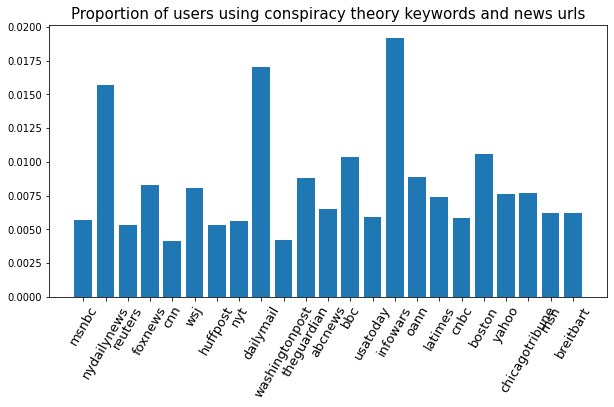

In [106]:
plt.figure(figsize=(10,5))
plt.title('Proportion of users using conspiracy theory keywords and news urls',size=15)
plt.bar(url_keys,url_props)
plt.xticks(rotation=60,fontsize=13)
plt.show()

In [57]:
# Heatmap matrix for each news website as proportion on users who also link to specific news sites
user_consp_dict = {'qanon':qanon_users,'pizza':pizza_users}
# user_consp_dict = {'qanon':qanon_users}

heatmap_matrix = np.zeros((len(url_dict),len(user_consp_dict)))

for i,(urlkey,urlval) in enumerate(url_dict.items()):
    for j,(userkey,userval) in enumerate(user_consp_dict.items()):
        heatmap_matrix[i,j] = len((set(urlval).intersection(set(userval))))/(len(userval)*len(urlval))*100*100

In [58]:
num_user_keys = [consp + '\n' + str(len(user_consp_dict[consp])) + ' users' for consp in user_consp_dict.keys()]

In [59]:
plt.figure(figsize=(10,8))
sns.heatmap(heatmap_matrix, xticklabels=num_user_keys, yticklabels=news_sources,vmin=0)
plt.title('Proportion of users who also link to news websites\n',fontsize=15)
plt.yticks(fontsize=13)
plt.xticks(rotation=20,fontsize=13)
plt.show()

ValueError: zero-size array to reduction operation fmax which has no identity

<Figure size 720x576 with 0 Axes>

### Drill down on bots

In [224]:
# general_botscores = 0

In [120]:
# Include non conspiracy theory users
user_consp_dict = {'qanon':qanon_users}
num_user_keys = [consp + '\n' + str(len(user_consp_dict[consp])) + ' users' for consp in user_consp_dict.keys()]

In [226]:
heatmap_matrix_bots = np.zeros((len(url_dict),len(user_consp_dict)))

for i,(urlkey,urlval) in enumerate(url_dict.items()):
    for j,(userkey,userval) in enumerate(user_consp_dict.items()):
        
        users = list(set(urlval).intersection(set(userval)))
        score_list = []
        for user in users:
            if all_botdict_en.get(user):
                score_list.append(all_botdict_en.get(user))
        if len(score_list) > 10:
            heatmap_matrix_bots[i,j] = sum(score_list)/len(score_list)
        else:
            heatmap_matrix_bots[i,j] = np.mean(list(all_botdict_en.values()))
        

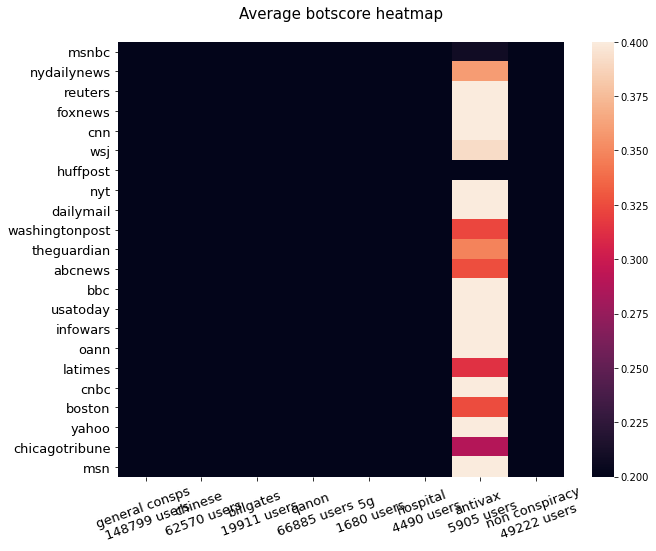

In [227]:
plt.figure(figsize=(10,8))
plt.title('Average botscore heatmap\n',fontsize=15)
sns.heatmap(heatmap_matrix_bots, xticklabels=num_user_keys, yticklabels=news_sources,vmax=0.4,vmin=0.2)
plt.yticks(fontsize=13)
plt.xticks(rotation=20,fontsize=13)
plt.show()

### Frequency plot of urls
General compared to conspiracy dataset

In [129]:
# Gets a dictionary of number of times urls are used above a threshold value
def get_url_counts(df,num_urls):
    url_df = df[df.urls_list != '[]'].reset_index()
    url_freq = [] 
    for i, row in url_df.iterrows():
        for url in ast.literal_eval(row.urls_list):
            url_freq.append(url['display_url'].split('/')[0])
            
    url_counts = Counter(url_freq)
    sorted_urls = {k: v for k, v in sorted(url_counts.items(), key=lambda item: item[1],reverse=True)[:num_urls]}
    print(sorted_urls)
    return sorted_urls

In [130]:
sorted_control_urls = get_url_counts(tot_df,30)
# sorted_control_urls = get_url_counts(control_df,30)
sorted_consp_urls = get_url_counts(df,30)
# sorted_consp_urls = get_url_counts(df,30)

{'twitter.com': 953012, 'youtu.be': 95680, 'pscp.tv': 46548, 'foxnews.com': 39465, 'youtube.com': 38644, 'breitbart.com': 37547, 'iwillvote.com': 33101, 'nytimes.com': 28075, 'cbsnews.com': 15376, 'cnn.com': 15074, 'facebook.com': 14900, 'google.com': 14338, 'washingtonpost.com': 13791, 'bit.ly': 13247, 'mobile.twitter.com': 9037, 'apple.news': 7654, 'joebiden.com': 7508, 'rawstory.com': 7253, 'businessinsider.com': 7047, 'm.youtube.com': 6753, 'theguardian.com': 6708, 'nbcnews.com': 6348, 'forbes.com': 6174, 'thehill.com': 5966, 'theconservativetreehouse.com': 5059, 'washingtontimes.com': 4981, 'thegatewaypundit.com': 4795, 'politico.com': 4792, 'apnews.com': 4379, 'thedcpatriot.com': 4210}
{'breitbart.com': 270409, 'cnn.com': 160695, 'foxnews.com': 158699, 'washingtonpost.com': 148602, 'nytimes.com': 121141, 'twitter.com': 114972, 'theguardian.com': 40759, 'google.com': 40003, 'msnbc.com': 37485, 'usatoday.com': 31519, 'cnbc.com': 30010, 'huffpost.com': 29998, 'wsj.com': 24698, 'news

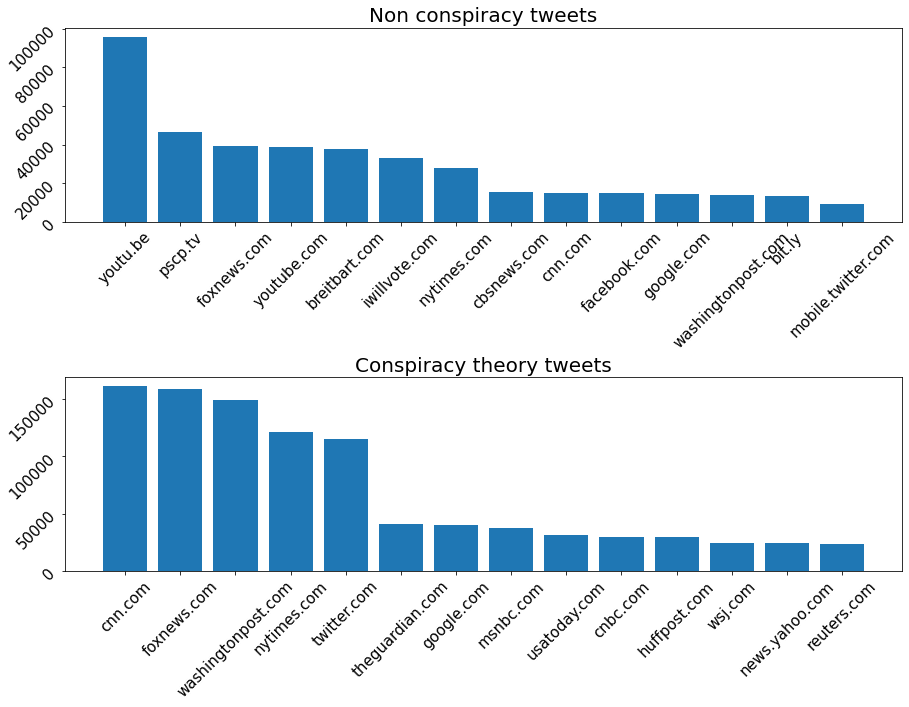

In [123]:
fig, ax = plt.subplots(2,1,figsize=(15,10))
ax[0].bar(list(sorted_control_urls.keys())[1:15], list(sorted_control_urls.values())[1:15])
ax[0].set_title('Non conspiracy tweets',fontsize=20)
ax[1].bar(list(sorted_consp_urls.keys())[1:15], list(sorted_consp_urls.values())[1:15])
ax[1].set_title('Conspiracy theory tweets',fontsize=20)
ax[0].tick_params(labelrotation=45,labelsize=15)
ax[1].tick_params(labelrotation=45,labelsize=15)
plt.subplots_adjust(hspace = 0.8)
plt.show()

### Temporal analysis

In [60]:
# Maps tweet df date record to pd.Timestamp
def get_date(x):
    date_parts = x.split(' ')
    date = '-'.join([date_parts[1]] + [date_parts[2]] + [date_parts[5]])
    return pd.Timestamp(date)

In [61]:
# # Maps tweet df date and hour record to pd.Timestamp
def get_date_hour(x):
    date_parts = x.split(' ')
    if len(date_parts) < 5:
        return pd.Timestamp('00:00:00')
    date = '-'.join([date_parts[1]] + [date_parts[2]] + [date_parts[5]]) 
    date = pd.Timestamp(date) + pd.Timedelta(hours = int(date_parts[3][0:2]))
    return date

# dates_df = df.date.apply(get_date_hour)

In [62]:
# Create placeholder df for dates
df.date = df.date.apply(get_date)
date_df = pd.DataFrame(columns=list(user_consp_dict.keys()),index=pd.date_range(start=df.date.min(),end=df.date.max()))
date_df.fillna(0,inplace=True)

In [63]:
for consp_df, consp_name in zip([qanon_df_h, pizza_df_h],list(user_consp_dict.keys())):
    dates = consp_df.date.apply(get_date)
    for date in dates.values:
        date_df.loc[date,consp_name] += 1

date_df.describe()

,qanon,pizza
count,79.000000,79.000000
mean,16635.037975,370.974684
std,22331.904504,213.597511
min,4082.000000,56.000000
25%,6294.000000,204.000000
50%,9133.000000,355.000000
75%,16990.000000,514.000000
max,173555.000000,1148.000000


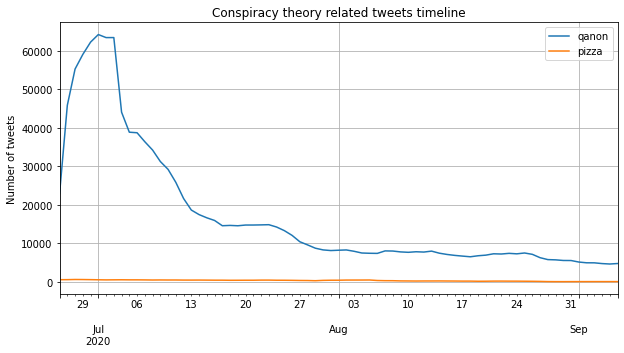

In [64]:
# Smoothed volume of consp hashtags over time
rolling_mean = date_df.rolling(7).mean().dropna()
rolling_mean.plot(y=date_df.columns,use_index=True,figsize=(10,5),fontsize=10)
plt.ylabel('Number of tweets')
plt.title('Conspiracy theory related tweets timeline')
plt.grid()

# Bot analysis

## Get user handles for botometer

Getting screen names to query using Botometer

In [38]:
account_totals = df[['userid','screen_name']].groupby(['userid','screen_name']).size()
account_totals.sort_values(ascending=False)

KeyboardInterrupt: 

In [131]:
account_totals = account_totals.sort_values(ascending=False)

/Users/jaimin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [118]:
url_props = [vals/tots for vals,tots in zip(url_consp_values,url_tots)]

## Load botscore queries

In [34]:
# Get botometer scores from conspiracy users
def botometer_query(filename,name_list):

    rapidapi_key = "6ac8fe69aamshcc30411e7824b49p12a1cajsnc2267278951c" # now it's called rapidapi key
    twitter_app_auth = {
        'consumer_key': 'DPIuUoHQsmaeK7UCyQZPxk1pD',
        'consumer_secret': 'SLDDw1VCdbF1ZpWl8xnNRekgw2Occd7ltVPuxo4tfyTZRPd8aq',
        'access_token': '1239432784319406080-vcW86zKro0M7e5pszZvRvAyXIVFy96',
        'access_token_secret': 'VlphE7Es3sjviibpmCmpTT1GdbZ180awYtE6FpKHR6qhl',
      }

    botometer_api_url = 'https://botometer-pro.p.rapidapi.com'
    bom = botometer.Botometer(botometer_api_url=botometer_api_url,
                              wait_on_ratelimit=True,
                              rapidapi_key=rapidapi_key,
                              **twitter_app_auth)

    # Check a single account by screen name
    result = bom.check_account('@clayadavis')

    # Check a single account by id
    result = bom.check_account(1548959833)

    # Check a sequence of accounts
    for screen_name, result in bom.check_accounts_in(name_list):

        this_acc = screen_name
        with open(filename, 'a+') as file:
            file.write('%s\n' % json.dumps(result))

In [35]:
# Returns a list of jsons of each uesr
def read_bot_csv(csv_name):
    file = open(csv_name)
    return file.readlines()

In [36]:
def get_antivax_botscores(df):
    cols = ['screen_name', 'english_botscore']
    user_scores = pd.DataFrame(columns = cols)
    for i in range(len(df)):
        botjson = json.loads(df.iloc[i].json)
        if botjson.get('user').get('user_data'):
            user_scores = user_scores.append(pd.DataFrame({'screen_name':[botjson['user']['user_data']['screen_name']].lower(), 
                                     'english_botscore':[botjson['cap']['english']]}))
        else:
            user_scores = user_scores.append(pd.DataFrame({'screen_name':[botjson['user']['screen_name']].lower(), 
                                     'english_botscore':[botjson['cap']['english']]}))
    user_scores.reset_index(inplace=True,drop=True)
    return user_scores

In [37]:
# Get dictionary of botscores from list of botometer json
def users_dict(json_list):
    bot_dict = {}
    for user in json_list:
        this_user = json.loads(user)
        if this_user.get('user'):
            if this_user.get('user').get('user_data'):
                bot_dict[this_user['user']['user_data']['screen_name'].lower()] = this_user['cap']['english']
            else:
                bot_dict[this_user['user']['screen_name'].lower()] = this_user['cap']['english']
    return bot_dict

In [38]:
botfile_path = 'Botometer_results/election/'
bot_consp_df = pd.read_csv(botfile_path + 'qanon_pizza_users.csv')
bot_consp_df.dropna(inplace=True)
print(bot_consp_df.shape)

bot_general_df = pd.read_csv(botfile_path + 'control_election_users.csv')
bot_general_df.dropna(inplace=True)
print(bot_general_df.shape)

(1216, 33)
(894, 33)


In [39]:
botscore_files = [botfile_path + i for i in os.listdir(botfile_path) if i[-3:] == 'csv']
print(botscore_files)
all_botscores = []
all_botdict_en = {}
for botfile in botscore_files:
#     if botfile.startswith('Botometer_results/antivax_results_jsons'):
#         continue
#     elif botfile.startswith('Botometer_results/antivax'):
#         these_botscores = read_bot_csv(botfile)

    these_botscores = read_bot_csv(botfile)
    all_botdict_en.update(users_dict(these_botscores))
    all_botscores += these_botscores

['Botometer_results/election/qanon_pizza_users.csv', 'Botometer_results/election/control_election_users.csv']


In [40]:
print('Number of botscores:',len(all_botscores))
print('Number of botscores:',len(all_botdict_en))

Number of botscores: 2355
Number of botscores: 2110


In [41]:
control_bot_files = [i for i in botscore_files if 'control' in i]
control_botscores = {}

for file in control_bot_files:
    these_scores = read_bot_csv(file)
    control_botscores.update(users_dict(these_scores))
len(control_botscores)

893

In [42]:
consp_bot_files = [i for i in botscore_files if 'control' not in i]
consp_botscores = {}

for file in consp_bot_files:
    these_scores = read_bot_csv(file)
    consp_botscores.update(users_dict(these_scores))

In [43]:
len(consp_botscores)

1217

In [44]:
print('Non conspiracy avg botscore:',sum(control_botscores.values())/ len(control_botscores))
print('Conspiracy avg botscore:',sum(consp_botscores.values())/ len(consp_botscores))

Non conspiracy avg botscore: 0.6101071894340465
Conspiracy avg botscore: 0.7377033377697653


In [45]:
# For url users for baseline comparison
url_bot_files = ['Botometer_results/botometer_general_06_03_unfinished.csv',
                  'Botometer_results/botometer_general_url - Copy.csv',
                  'Botometer_results/botometer_general_url_2 - Copy.csv',
                  'Botometer_results/url_general_bot_queries.csv',
                ]

url_bot_files = [
                  'Botometer_results/botometer_general_url - Copy.csv',
                  'Botometer_results/botometer_general_url_2 - Copy.csv',
                  'Botometer_results/url_general_bot_queries.csv',
                ]

url_botscores = {}

for file in url_bot_files:
    these_scores = read_bot_csv(file)
    url_botscores.update(users_dict(these_scores))

In [47]:
# # # Find Conspiracy theory users
# rt_scored_users = list(rt_df[rt_df['screen_name'].isin(set(all_botdict_en.keys()))].screen_name.unique())
# orig_scored_users = list(orig_df[orig_df['screen_name'].isin(set(all_botdict_en.keys()))].screen_name.unique())

In [202]:
# Get lists of scores
rt_scores = []
orig_scores = []
for name in rt_scored_users:
    rt_scores.append(all_botdict_en[name])
for name in orig_scored_users:
    orig_scores.append(all_botdict_en[name])

## Botscore Results

In [48]:
print(sum(rt_scores)/len(rt_scores))
print(sum(orig_scores)/len(orig_scores))

NameError: name 'rt_scores' is not defined

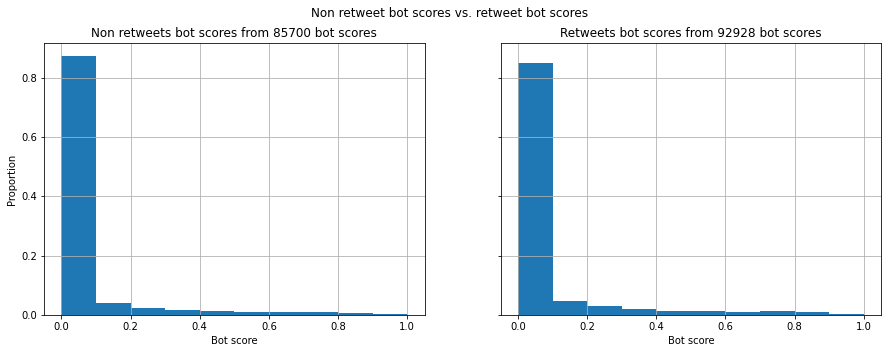

In [204]:
# Bot scores
fig, ax = plt.subplots(1,2,figsize=(15,5),sharey=True)
fig.suptitle('Non retweet bot scores vs. retweet bot scores')
ax[0].set_ylabel('Proportion')
ax[0].set_xlabel('Bot score')

ax[0].hist(orig_scores, weights=np.ones(len(orig_scores))/len(orig_scores))
ax[0].set_title('Non retweets bot scores from %d bot scores' % len(orig_scores))
ax[0].grid()

ax[1].set_xlabel('Bot score')
ax[1].hist(rt_scores, weights=np.ones(len(rt_scores))/len(rt_scores))
ax[1].set_title('Retweets bot scores from %d bot scores' % len(rt_scores))
ax[1].grid()
plt.show()

In [205]:
# Comparing botscores for conspiracy theories vs non conspiracy theoies
botvals_general = list(general_botscores.values())
botvals_consp = list(consp_botscores.values())

In [206]:
print('General',sum(botvals_general)/len(botvals_general))
print('Conspiracy',sum(botvals_consp)/len(botvals_consp))

General 0.053641498434632444
Conspiracy 0.06980268171802326


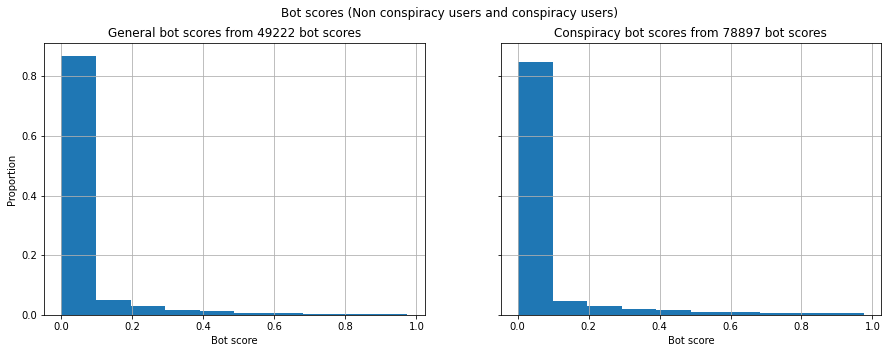

In [207]:
fig, ax = plt.subplots(1,2,figsize=(15,5),sharey=True)
fig.suptitle('Bot scores (Non conspiracy users and conspiracy users)')

ax[0].set_ylabel('Proportion')
ax[0].set_xlabel('Bot score')
ax[0].hist(botvals_general, weights=np.ones(len(botvals_general)) / len(botvals_general))
ax[0].set_title('General bot scores from %d bot scores' % len(botvals_general))
ax[0].grid()

ax[1].set_xlabel('Bot score')
ax[1].hist(botvals_consp, weights=np.ones(len(botvals_consp)) / len(botvals_consp))
ax[1].set_title('Conspiracy bot scores from %d bot scores' % len(botvals_consp))
ax[1].grid()
plt.show()

In [208]:
non_consp_users = set(list(general_botscores.keys()))

In [209]:
# Get botscores for each conspiracy theory
all_botdict_en_china = {}
all_botdict_en_bill = {}
all_botdict_en_qanon = {}
all_botdict_en_hosp = {}
all_botdict_en_fiveg = {}
all_botdict_en_antivax = {}
all_botdict_en_non_consp = {}

# all_botuser_set = set(all_botdict_en.keys())
for screen_name in all_botdict_en.keys():
    if screen_name in china_users:
        all_botdict_en_china[screen_name] = all_botdict_en[screen_name]
    if screen_name in bill_users:
        all_botdict_en_bill[screen_name] = all_botdict_en[screen_name]
    if screen_name in qanon_users:
        all_botdict_en_qanon[screen_name] = all_botdict_en[screen_name]
    if screen_name in hosp_users:
        all_botdict_en_hosp[screen_name] = all_botdict_en[screen_name]
    if screen_name in fiveg_users:
        all_botdict_en_fiveg[screen_name] = all_botdict_en[screen_name]
    if screen_name in antivax_users:
        all_botdict_en_antivax[screen_name] = all_botdict_en[screen_name]
    if screen_name in non_consp_users:
        all_botdict_en_non_consp[screen_name] = all_botdict_en[screen_name]
    
print(len(all_botdict_en_china))
print(len(all_botdict_en_bill))
print(len(all_botdict_en_qanon))
print(len(all_botdict_en_hosp))
print(len(all_botdict_en_fiveg))
print(len(all_botdict_en_antivax))
print(len(all_botdict_en_non_consp))

33356
6748
25125
3233
911
2441
49222


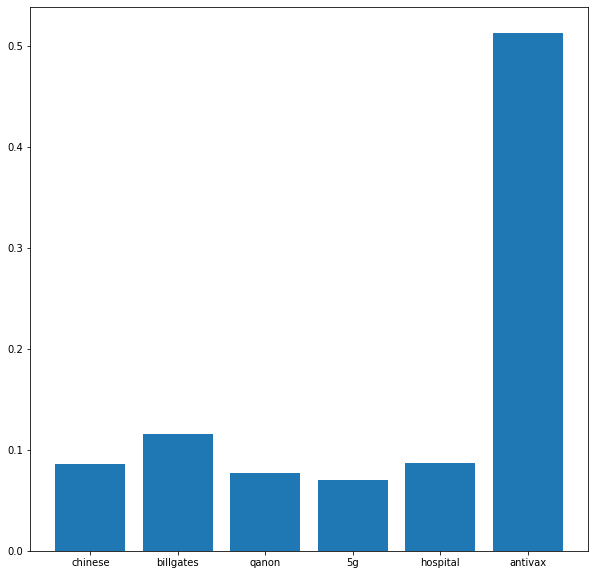

In [211]:
# Average botscore for each group of conspiracy theory users
fig = plt.figure(figsize = (10,10))

avg_botscores= [sum(list(all_botdict_en_china.values()))/len(all_botdict_en_china.values()),
                sum(list(all_botdict_en_bill.values()))/len(all_botdict_en_bill.values()),
                sum(list(all_botdict_en_qanon.values()))/len(all_botdict_en_qanon.values()),
                sum(list(all_botdict_en_hosp.values()))/len(all_botdict_en_hosp.values()),
                sum(list(all_botdict_en_fiveg.values()))/len(all_botdict_en_fiveg.values()),
                sum(list(all_botdict_en_antivax.values()))/len(all_botdict_en_antivax.values())]
#                 sum(list(all_botdict_en_non_consp.values()))/len(all_botdict_en_non_consp.values())]

plt.bar(list(user_consp_dict.keys())[1:],avg_botscores)

plt.show()

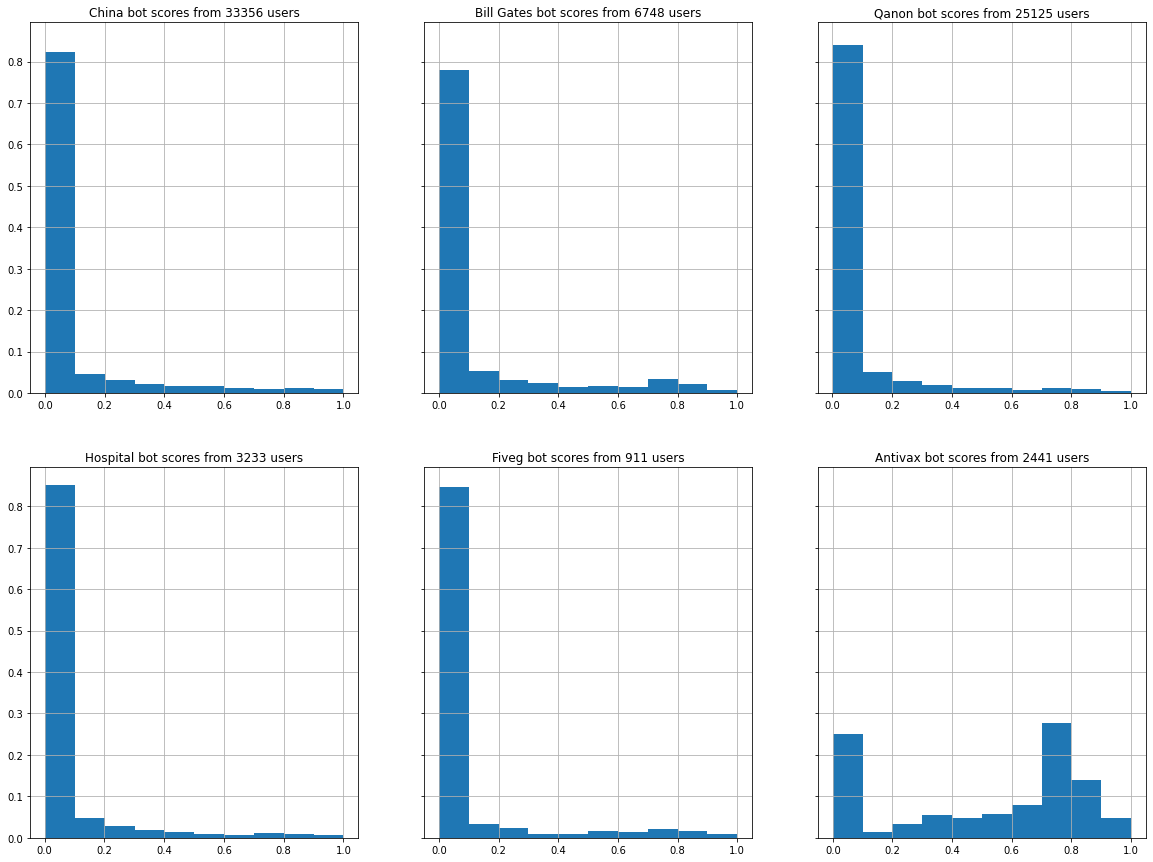

In [212]:
fig, ax = plt.subplots(2,3,figsize=(20,15) ,sharey=True)

ax[0,0].hist(all_botdict_en_china.values(), weights=np.ones(len(all_botdict_en_china)) / len(all_botdict_en_china))
ax[0,0].set_title('China bot scores from %d users' % len(all_botdict_en_china))
ax[0,0].grid()

ax[0,1].hist(all_botdict_en_bill.values(), weights=np.ones(len(all_botdict_en_bill)) / len(all_botdict_en_bill))
ax[0,1].set_title('Bill Gates bot scores from %d users' % len(all_botdict_en_bill))
ax[0,1].grid()

ax[0,2].hist(all_botdict_en_qanon.values(), weights=np.ones(len(all_botdict_en_qanon)) / len(all_botdict_en_qanon))
ax[0,2].set_title('Qanon bot scores from %d users' % len(all_botdict_en_qanon))
ax[0,2].grid()

ax[1,0].hist(all_botdict_en_hosp.values(), weights=np.ones(len(all_botdict_en_hosp)) / len(all_botdict_en_hosp))
ax[1,0].set_title('Hospital bot scores from %d users' % len(all_botdict_en_hosp))
ax[1,0].grid()

ax[1,1].hist(all_botdict_en_fiveg.values(), weights=np.ones(len(all_botdict_en_fiveg)) / len(all_botdict_en_fiveg))
ax[1,1].set_title('Fiveg bot scores from %d users' % len(all_botdict_en_fiveg))
ax[1,1].grid()

ax[1,2].hist(all_botdict_en_antivax.values(), weights=np.ones(len(all_botdict_en_antivax)) / len(all_botdict_en_antivax))
ax[1,2].set_title('Antivax bot scores from %d users' % len(all_botdict_en_antivax))
ax[1,2].grid()

plt.show()

# Find significant users

Finding prominent misinformation spreaders 

In [49]:
# Split into high and low botscores

In [50]:
# Split into high and low botscores
# Create dataframe for each user
# Columns = ['Number of tweets','Follower count','% Retweets','Account creation date','Botscore',All URLS, ALL CONSPIRACIES]

In [51]:
# conspiracies = [consp for consp in user_consp_dict.keys()]

In [65]:
user_columns = ['Screen Name','Botscore','Covid Tweets','Follower Count','Favourites Count','Retweets Count',
                'Non Retweets Count','Account Created','Location','Retweeted Count', 'Mentioned Count','Language',
                'User ID'] + [consp for consp in user_consp_dict.keys()]

user_df = pd.DataFrame(columns = user_columns)

In [66]:
from ast import literal_eval

In [71]:
df.isna().sum()

tweetid                       0
userid                        0
screen_name                   0
date                          0
lang                          0
location                 328004
text                          0
tweet_type                    0
followers_count               0
favourites_count              0
verified                      0
hashtag                       0
urls_list                     0
account_creation_date         0
mentionid                     0
mentionsn                     0
rt_screen                415309
rt_userid                415309
rt_rt_count                   0
rt_fav_count                  0
rt_tweetid               291564
dtype: int64

In [76]:
# Create the dataframe adding information for each tweet
user_df = pd.DataFrame(columns = user_columns)
already_added = dict()
already_added_id = dict()
retweet_dict = dict()
mention_dict = dict()

counter = 0
for index, row in tqdm(df.iloc[:,:].dropna(subset=['followers_count']).iterrows()):
#     break
    
    if int(row['followers_count']) < 1000:
        continue
    else:

        # If its a new entry
        if row['screen_name'] not in already_added:
            added = False

            already_added[row['screen_name']] = counter
            already_added_id[row['userid']] = counter
            
            
            user_row = pd.Series(index=user_columns).fillna(0)
            user_row['Screen Name','Follower Count','Favourites Count','User ID','Account Created','Location'
                     ,'Language'] = row[['screen_name','followers_count','favourites_count','userid',
                     'account_creation_date','location','lang']].values        
            
            break
            
            # Botscores
            user_row['Botscore'] = all_botdict_en.get(row['screen_name'])
            counter += 1

        # If there is already an entry for this user
        else:
            added = True
            idx = already_added[row['screen_name']]
            user_row = user_df.iloc[idx,:]

        user_row['Covid Tweets'] = user_row['Covid Tweets'] + 1

        if np.isnan(row['rt_userid']):
            user_row['Non Retweets Count'] = user_row['Non Retweets Count'] + 1
        else:
            user_row['Retweets Count'] = user_row['Retweets Count'] + 1
            if retweet_dict.get(row['rt_userid']):
                retweet_dict[row['rt_userid']] = retweet_dict[row['rt_userid']] + 1
            else:
                retweet_dict[row['rt_userid']] = 1

        # Add to mention and retweet count
        if type(row['mentionsn']) == str:
            if len(row['mentionsn']) > 2:
                mentions = literal_eval(row['mentionsn'])
                for mentionsn in mentions:
                    if mention_dict.get(mentionsn):
                        mention_dict[mentionsn] = mention_dict[mentionsn] + 1
                    else:
                        mention_dict[mentionsn] = 1

        if row['screen_name'] in qanon_users:
            user_row['qanon'] = user_row['qanon'] + 1
        
        if row['screen_name'] in qanon_users:
            user_row['pizza'] = user_row['pizza'] + 1

#         for url, url_vals in url_consp_users.items():
#             if row['screen_name'] in url_vals:
#                 user_row[url] = user_row[url] + 1

        if not added:
            user_df = user_df.append(user_row,ignore_index=True)
        else:
            user_df.update(pd.DataFrame(user_row).T)

# user_df

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['user_id'], dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [25]:
# {k: v for k, v in sorted(mention_dict.items(), key=lambda item: item[1], reverse=True)}

In [338]:
for i,row in tqdm(user_df.iloc[:,:].iterrows()):
    if row['followers_count'] < 1000:
        pass
    else:

In [345]:
# user_df.to_csv('tweeter_info.csv')
user_df.sort_values('Covid Tweets',ascending=False)
# user_df.sort_values('Botscore')

,Screen Name,Botscore,Covid Tweets,Follower Count,Favourites Count,Retweets Count,Non Retweets Count,Account Created,Location,Retweeted Count,...,boston,yahoo,chicagotribune,msn,general conspiracies,china lies,billgates,qanon,5g,hospital
1068,r__worldnews,0.70642,303,214,0,0,303,fri dec 29 19:18:05 +0000 2017,NaN,0,...,0,0,0,0,0,0,0,0,0,0
455,viriyabot,0.813872,211,861,56,211,0,thu jul 14 12:47:03 +0000 2016,internet,0,...,211,211,0,211,0,211,0,0,0,0
894,skowtura_ini,None,204,608,118,0,204,sat jan 31 01:55:19 +0000 2015,uk,0,...,204,204,204,204,0,0,0,0,0,0
279,dubvnow,None,144,11030,51785,0,144,mon mar 19 01:02:16 +0000 2012,"morgantown, wv",0,...,0,0,0,0,0,0,0,0,0,0
17143,baronianconsult,None,128,1601,80902,53,75,wed jun 05 21:52:49 +0000 2013,NaN,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30555,mariaeugeniarc,None,1,585,13885,0,1,thu mar 25 21:03:13 +0000 2010,mexico,0,...,0,0,0,0,0,0,0,0,0,0
30556,tbygracezhu,None,1,1021,169,0,1,mon jun 22 11:59:25 +0000 2009,beijing,0,...,0,0,0,0,0,0,0,0,0,0
30557,drjoaquinid,None,1,92,39,1,0,mon jul 22 14:52:36 +0000 2019,NaN,0,...,0,0,0,0,0,0,0,0,0,0
30558,lamichhanen,None,1,538,3286,0,1,sat sep 07 11:27:20 +0000 2013,"bharatpur, nepal",0,...,0,0,0,0,0,0,0,0,0,0


In [324]:
# with open('retweet_dict.json','w') as file:
#     json.dump(retweet_dict,file)
# # with open('url_users.json', 'w') as outfile:
# #     json.dump(str(url_general_users), outfile)
# with open('mention_dict.json','w') as file:
#     json.dump(mention_dict,file)
# user_df = pd.read_csv('tweeter_info.csv',index_col=0)
# user_df.sort_values('Retweeted Count')
# with open('jsons/mention_dict.json') as json_file:
#     mention_dict_old = json.load(json_file)

In [73]:
user_columns

['Screen Name',
 'Botscore',
 'Covid Tweets',
 'Follower Count',
 'Favourites Count',
 'Retweets Count',
 'Non Retweets Count',
 'Account Created',
 'Location',
 'Retweeted Count',
 'Mentioned Count',
 'Language',
 'User ID',
 'qanon',
 'pizza']

In [58]:
df.describe()

,tweetid,userid,screen_name,date,lang,location,text,tweet_type,followers_count,favourites_count,verified,hashtag,urls_list,account_creation_date,mentionid,mentionsn,rt_userid
count,322686,322686,322686,322686,322686,186684,322686,322686,322686,322686,322686,322686,322686,322686,322686,322686,115756
unique,176594,90018,90706,170031,52,21571,107833,4,20465,62058,2,61465,31107,89996,31719,31811,9148
top,1254093321829580801,49992656,joyceramgatie,wed apr 08 02:49:03 +0000 2020,en,united states,rt @qnotables1: soros owns biotech company in ...,retweeted_tweet_without_comment,0,0,false,[qanon],[],tue jun 23 14:39:59 +0000 2009,[],[],1.163085970901631e+18
freq,11,1436,1436,14,250226,11043,2247,115756,4679,2891,322171,19186,240536,1436,102377,102377,2887


## Original Tweets

In [201]:
# Only include original tweets
all_df = orig_df[orig_df.tweet_type == 'original']
all_df.dropna(subset=['hashtag'],inplace=True)
all_df[['followers_count','favourites_count']] = all_df[['followers_count','favourites_count']].astype('float')

/Users/jaimin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [202]:
bill_df = all_df[all_df['screen_name'].isin(bill_users)]
fiveg_df = all_df[all_df['screen_name'].isin(fiveg_users)]
china_df = all_df[all_df['screen_name'].isin(china_users)]
hosp_df = all_df[all_df['screen_name'].isin(hosp_users)]

### By follower count

In [203]:
print(bill_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
bill_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['dalenekurtis' 'jamierodr14' 'libertytarian' 'no_democrats' 'kidkool4u'
 'hickorymtnman' 'bamafanaticfan1' 'sherry25793049' 'tmzedg'
 'eavesdropann' 'christinepolon1' 'stephphilip8' 'notunderdog'
 'jpharley3000' 'enki74' 'yourauntiemame' 'toscaausten' 'chesleydohl'
 'jebeess34' 'viku1111']


,tweetid,userid,screen_name,date,lang,location,text,tweet_type,followers_count,favourites_count,verified,hashtag,urls_list,account_creation_date,mentionid,mentionsn,rt_userid
129868,1222517778973851649,244241866,dalenekurtis,wed jan 29 13:52:06 +0000 2020,en,"newport beach,ca•nashville,tn",coronavirus infected are trying to spread the ...,original,197669.0,32921.0,True,[cononavirus],"[{'url': 'https://t.co/zr5xrgyags', 'expanded_...",fri jan 28 21:31:42 +0000 2011,[],[],NaN
1423373,1238975687790415872,3353061012,jamierodr14,sat mar 14 23:49:57 +0000 2020,en,georgia,boom! \n\ntrump was right! \n\nthe fake news m...,original,132299.0,451068.0,False,[],"[{'url': 'https://t.co/otpjpngzej', 'expanded_...",wed aug 26 22:51:25 +0000 2015,[],[],NaN
2156944,1252710238656040969,590211920,libertytarian,tue apr 21 21:26:09 +0000 2020,en,tx,connecticut — always first in tyranny\n\n#soci...,original,127236.0,7222.0,False,"[socialdistancing, constitutiondistancing]","[{'url': 'https://t.co/hfydwkz5qr', 'expanded_...",fri may 25 18:34:05 +0000 2012,[],[],NaN
307205,1224689435226394626,59461030,no_democrats,tue feb 04 13:41:29 +0000 2020,en,usa,figure out who really owns cnn and msnbc and c...,original,81811.0,6696.0,False,"[exposecnn, facebook, deepstate, exposemsnbc, ...",[],thu jul 23 13:28:23 +0000 2009,[],[],NaN
2342953,1255668392972955649,2827135812,kidkool4u,thu apr 30 01:20:48 +0000 2020,en,"toronto, on, ca",must watch! #covid19 #plandemic https://t.co/g...,original,54052.0,144021.0,False,"[covid19, plandemic]","[{'url': 'https://t.co/guqkwdf1zg', 'expanded_...",tue sep 23 00:46:55 +0000 2014,[],[],NaN
2291235,1254775975222456321,914154046382051328,hickorymtnman,mon apr 27 14:14:39 +0000 2020,en,NaN,warning friends\n\nthere are shortages coming ...,original,52893.0,84838.0,False,[],"[{'url': 'https://t.co/lfwkkddpn0', 'expanded_...",sat sep 30 15:44:43 +0000 2017,[],[],NaN
2155183,1252698632895311877,997312910748680192,bamafanaticfan1,tue apr 21 20:40:02 +0000 2020,en,tx,senate leaders reach agreement on $500b 'phase...,original,49368.0,89770.0,False,[],"[{'url': 'https://t.co/1zk78pie2w', 'expanded_...",fri may 18 03:08:21 +0000 2018,[],[],NaN
1182755,1235040423002992640,949672435690934274,sherry25793049,wed mar 04 03:12:37 +0000 2020,en,"chicago, il",dr. drew: media-driven panic over coronavirus ...,original,46781.0,190454.0,False,[],"[{'url': 'https://t.co/hxmbavgm1e', 'expanded_...",sat jan 06 16:02:07 +0000 2018,[],[],NaN
2138593,1252395308660613120,996576181251117056,tmzedg,tue apr 21 00:34:44 +0000 2020,en,"columbus, oh",as more data comes in showing\ncoved19 is far ...,original,46071.0,26143.0,False,[],"[{'url': 'https://t.co/v91ymwhvbe', 'expanded_...",wed may 16 02:20:51 +0000 2018,[],[],NaN
2268906,1254380037232635904,134240162,eavesdropann,sun apr 26 12:01:20 +0000 2020,en,michigan u.s.a.,steve bannon on holding china accountable for ...,original,44954.0,2038.0,False,[],"[{'url': 'https://t.co/ptqgkemn2b', 'expanded_...",sat apr 17 21:22:31 +0000 2010,[],[],NaN


In [164]:
print(china_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# china_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['jagrannews' 'tarekfatah' 'mrsgandhi' 'edoilustrado' 'epochtimes'
 'joshrogin' 'presstv' 'mikandynothem' 'danielmaithyake' 'gatimumuchai'
 'sasscbrown' 'davidwebbshow' 'amerikangirlll' 'adammilstein'
 'jenniferatntd' 'cofekrebranded' 'jkylebass' 'jamierodr14' 'rwang0'
 'erotao']


In [165]:
print(fiveg_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# fiveg_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['financialxpress' 'jonbenjamin19' 'paoloigna1' 'adjunctprofesor'
 'thelastpiratela' 'no_democrats' 'honourablehappy' 'seefinish' 'viku1111'
 'worldnewsdotcom' 'gizmothegreates' 'photoframd' 'hsnewslive' 'jhsty'
 'cvonpetzholdt' 'alexwitzleben' 'clim8resistance' 'ulumbamulumba'
 'thomas_binder' 'pcf_official']


In [166]:
print(hosp_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# hosp_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['gaetasusan' 'toypilanews' 'mdj17' 'patrici15767099' 'elixiumcrypto'
 'lloyd4man' 'luciahoff' 'drnealhouston' 'notatsclassy' 'katrina_wiser'
 'vanessabeeley' 'kagrox' 'amuse' 'claralkatzenmai' 'icare4america16'
 'risetoflyy' 'drsharonking' 'surfphx' 'enki74' 'lotusoak2']


## Retweets only

In [183]:
# Only include original tweets
all_df = rt_df[rt_df.tweet_type.isin(['retweeted_tweet_without_comment'])]
all_df.dropna(subset=['hashtag'],inplace=True)
all_df[['followers_count','favourites_count']] = all_df[['followers_count','favourites_count']].astype('float')

In [184]:
bill_df = all_df[all_df['screen_name'].isin(bill_users)]
fiveg_df = all_df[all_df['screen_name'].isin(fiveg_users)]
china_df = all_df[all_df['screen_name'].isin(china_users)]
hosp_df = all_df[all_df['screen_name'].isin(hosp_users)]

### By follower count

In [189]:
print(bill_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# bill_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['dalenekurtis' 'jamierodr14' 'anthemrespect' 'superyayadize'
 '__kimberly1' 'mazurikl' 'drthomaspaul' 'rninmi' 'anonagain3'
 'patriqtscott' 'kidkool4u' 'hickorymtnman' 'bsgirl2u' 'bamafanaticfan1'
 'sherry25793049' 'tmzedg' 'eavesdropann' 'christinepolon1'
 'debbideedoodah' 'stephphilip8']


In [190]:
print(china_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# china_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['jimparedes' 'obyezeks' 'nikkibenz' 'alibabagcfr' 'tarekfatah'
 'steph93065' 'muslimmatters' 'epochtimes' 'joshrogin' 'mikandynothem'
 'sidneypowell1' 'sxdoc' 'danielmaithyake' 'drmartyfox' 'drawandstrike'
 'uyandam' 'traderbesi' 'sasscbrown' 'amerikangirlll' 'adammilstein']


In [191]:
print(fiveg_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# fiveg_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['jonbenjamin19' 'paoloigna1' 'adjunctprofesor' 'honourablehappy'
 'jolyonrubs' 'phtraffic' 'piers_corbyn' 'blue21sky' 'tweet_humor'
 'bozenafox' 'cathibrgnr58' 'iimghost' 'was3210' 'iamswagodking'
 'happykat9' 'leftnotright' 'lapidostrous' 'perihankedi' 'kenorivero'
 'anonymoussage1']


In [192]:
print(hosp_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# hosp_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['darthlux' 'france24_en' 'gaetasusan' 'toypilanews' 'johnjbrea'
 'dgpurser' 'donnawr8' 'darhar981' 'exdemlatina' 'missilmom' 'cjdtwit'
 'gmanfan45' 'cajun4trump' 'elixiumcrypto' 'lloyd4man' 'sickoftheswamp'
 'luciahoff' 'drnealhouston' 'xarmandkleinx' 'orenishikiddo']


# Network Analysis

Mapping the network topology in terms of conspiracies, users and urls

In [112]:
import networkx as nx

In [113]:
users_list = [bill_users,china_users,fiveg_users,hosp_users,qanon_users]

In [114]:
g = nx.Graph()

In [115]:
users_list = [china_users,bill_users,fiveg_users,hosp_users,qanon_users]

In [116]:
print(len(fiveg_users))

1070


In [129]:
# Get tweets, create a cloud, get users associated with each url substring
def get_hashtags_tweets_graph(df,hashtag_list,g):
    users = set()
    hash_dict = {}
    hash_df = pd.DataFrame()

    for hashtag in tqdm(hashtag_list):
        these_hashtags = hash_tweets(hashtag,df)
        hash_df = hash_df.append(these_hashtags)
        hash_dict[hashtag] = these_hashtags.screen_name.unique()
        these_users = list(these_hashtags.screen_name.unique())
        users.update(these_users)
        
        g.add_node(hashtag,ishashtag=1)
        
        for user in these_users:
            g.add_edge(user,hashtag,weight=len(hash_df[hash_df.screen_name == user]))
        
    
    return list(users), hash_dict, hash_df

In [130]:
# Get tweets, create a cloud, get users associated with each url substring
def get_url_usertweets_graph(df,url_list,g):
    users = set()
    url_dict = {}
    url_df = pd.DataFrame()

    for url in tqdm(url_list):
        these_urls = url_tweets(url,df)
        url_df = url_df.append(these_urls)
        url_dict[url] = these_urls.screen_name.unique()
         
        g.add_node(url,isurl=1)
        for user in list(these_urls.screen_name.unique()):
            g.add_edge(user,url,weight=len(url_df[url_df.screen_name == user]))
    
    return list(users), url_dict, url_df

In [119]:
tweet_df = df.dropna(subset=['hashtag'])
tweet_df.reset_index(drop=True,inplace=True)
tweet_df = tweet_df.apply(lambda x: x.astype(str).str.lower())
tweet_df.replace('nan',np.nan,inplace=True)
tweet_df.hashtag = tweet_df.hashtag.str.replace("'", '')

In [132]:
g = nx.DiGraph()
df = pd.DataFrame()

# Get only conspiracy and url with news chanel related tweets

print('General')
general_users_h, general_dict_h, general_df_h = get_hashtags_tweets_graph(tweet_df,general_keywords,g)
print('China')
china_users_h, china_dict_h, china_df_h = get_hashtags_tweets_graph(tweet_df,china_keywords,g)
print('Bill')
bill_users_h, bill_dict_h, bill_df_h = get_hashtags_tweets_graph(tweet_df,bill_keywords,g)
print('5g')
fiveg_users_h, fiveg_dict_h, fiveg_df_h = get_hashtags_tweets_graph(tweet_df,fiveg_keywords,g)
print('Hosp')
hosp_users_h, hosp_dict_h, hosp_df_h = get_hashtags_tweets_graph(tweet_df,hosp_keywords,g)
print('Qanon')
qanon_users_h, qanon_dict_h, qanon_df_h = get_hashtags_tweets_graph(tweet_df,qanon_keywords,g)


tweet_df_urls = tweet_df[tweet_df.urls_list!='[]']

# # Get tweets, create a cloud, get users associated with each news source
url_users, url_dict_temp, news_url_df = get_url_usertweets_graph(tweet_df_urls.iloc[::10,:],news_sources,g)
for urlkey,urlval in url_dict_temp.items():
    this_set = set(urlval)
    if url_dict.get(urlkey):
        this_set.update(url_dict.get(urlkey))
    url_dict[urlkey]=this_set


General



China



Bill



5g



Hosp



Qanon


In [135]:
nx.write_gml(g, "user_hashtag_url_3.gml")

In [136]:
print(len(g.nodes))
print(len(g.edges))

235892
327646


In [368]:
g = nx.Graph()
hashtag_names = ['china_hashtags','billgates_hashtags','5G_hashtags','hospital_hashtags','qanon_hashtags']
g.add_nodes_from(hashtag_names)

for idx, users in enumerate(users_list):
    for idx2, i in enumerate(users):
        if i == :
            
        if not g.has_node(i):
            g.add_node(i)
        g.add_edge(i,hashtag_names[idx])

In [369]:
print(len(g.nodes))
print(len(g.edges))

5167
5350


In [370]:
nx.write_gml(g, "users_consps.gml")

In [355]:
plt.figure(figsize=(10,10))
nx.draw_networkx(g, pos=None, width=0.01, with_labels=False, node_size=10)
plt.show()

KeyboardInterrupt: 

<Figure size 720x720 with 0 Axes>

# Conspiracy tweet location data

In [78]:
# !pip install plotly
import plotly.graph_objects as go

     |████████████████████████████████| 13.0 MB 3.1 MB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11430 sha256=d1a066201393c2793c406bb8b56cce3ff1573e84d2cbb5a565eaf2fc6fdf6d20
  Stored in directory: /nas/home/jpatel/.cache/pip/wheels/c4/a7/48/0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying


In [80]:
states = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
  "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
  "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
  "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
  "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
  "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
  "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
  "Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [131]:
# Plots a map of relative proportion of tweets with a specific hashtag from each state
def plot_us_consp_map(df, specific_df,consp_str):
    loc_df = specific_df.dropna(subset=['location'])
    reg_loc_df = df.dropna(subset=['location'])

    consp_states = {} # no. of conpiracy tweets in each state
    reg_states = {} # no. of tweets in each state 
    consp_usernames = {} # dfs for hashtag analysis

    for state in tqdm(states):
        consp_usernames[us_state_abbrev[state]] = loc_df[loc_df.location.str.contains(state.lower())]
        consp_states[us_state_abbrev[state]] = len(loc_df[loc_df.location.str.contains(state.lower())])
        reg_states[us_state_abbrev[state]] = len(reg_loc_df[reg_loc_df.location.str.contains(state.lower())])
        
    state_props = dict(zip(list(consp_states.keys()), [x/y*(len(sample_files)/len(csv_files))  for x, y in zip(list(consp_states.values()),list(reg_states.values()))]))
    
    fig = go.Figure(data=go.Choropleth(
    locations=list(state_props.keys()), # Spatial coordinates
    z = list(state_props.values()), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Relative Proportion"))

    fig.update_layout(title_text='Proportion of tweets using '+consp_str+' keyword',geo_scope='usa')
    fig.show()
    
    return consp_states

In [120]:
clouds = False
# Using normal df
qanon_users_h, qanon_dict_h, qanon_df_h = get_hashtags_tweets(df,['qanon'],cloud=clouds)
greatawakening_users_h, greatawakening_dict_h, greatawakening_df_h = get_hashtags_tweets(df,['greatawakening'],cloud=clouds)
wwg1wga_users_h, wwg1wga_dict_h, wwg1wga_df_h = get_hashtags_tweets(df,['wwg1wga'],cloud=clouds)
qarmy_users_h, qarmy_dict_h, qarmy_df_h = get_hashtags_tweets(df,['qarmy'],cloud=clouds)
pizzagate_users_h, pizzagate_dict_h, pizzagate_df_h = get_hashtags_tweets(df,['pizzagate'],cloud=clouds)


qanon num tweets: 425296
qanon unique users: 74217

greatawakening num tweets: 183302
greatawakening unique users: 31170

wwg1wga num tweets: 567029
wwg1wga unique users: 85334

qarmy num tweets: 138541
qarmy unique users: 17738

pizzagate num tweets: 29307
pizzagate unique users: 12454


In [132]:
consp_states = plot_us_consp_map(control_df, qanon_df_h,'qanon')
print(consp_states)

{'AL': 1805, 'AK': 536, 'AZ': 2152, 'AR': 451, 'CA': 6010, 'CO': 1472, 'CT': 407, 'DE': 276, 'FL': 5831, 'GA': 1401, 'HI': 1317, 'ID': 666, 'IL': 970, 'IN': 1197, 'IA': 495, 'KS': 898, 'KY': 950, 'LA': 802, 'ME': 377, 'MD': 439, 'MA': 501, 'MI': 2203, 'MN': 749, 'MS': 616, 'MO': 1208, 'MT': 394, 'NE': 152, 'NV': 302, 'NH': 380, 'NJ': 1028, 'NM': 379, 'NY': 2929, 'NC': 1452, 'ND': 49, 'OH': 1805, 'OK': 1522, 'OR': 1215, 'PA': 1924, 'RI': 84, 'SC': 819, 'SD': 122, 'TN': 1542, 'TX': 9053, 'UT': 513, 'VT': 44, 'VA': 1422, 'WA': 3872, 'WV': 325, 'WI': 700, 'WY': 109}


In [ ]:
wwg1wga_consp_states = plot_us_consp_map(control_df, wwg1wga_df_h,'wwg1wga')
print(wwg1wga_consp_states)

# N Grams analysis

In [ ]:
qanon_df.text

In [211]:
print('Conspiracy tweets')
ngram_counts = Counter(ngrams(all_consp_text.split(), 2))
ngram_counts.most_common(10)

Conspiracy tweets


[(('#qanon', '#wwg1wga'), 49),
 (('about', 'coronavirus.'), 37),
 (('@sun_q_tzu:', 'brilliant'), 36),
 (('brilliant', 'clip'), 36),
 (('clip', 'from'), 36),
 (('from', 'drew!'), 36),
 (('drew!', 'nails'), 36),
 (('nails', 'fakenews'), 36),
 (('fakenews', 'overreacting'), 36),
 (('overreacting', 'about'), 36)]

In [212]:
ngram_counts = Counter(ngrams(all_consp_text.split(), 3))
ngram_counts.most_common(10)

[(('@sun_q_tzu:', 'brilliant', 'clip'), 36),
 (('brilliant', 'clip', 'from'), 36),
 (('clip', 'from', 'drew!'), 36),
 (('from', 'drew!', 'nails'), 36),
 (('drew!', 'nails', 'fakenews'), 36),
 (('nails', 'fakenews', 'overreacting'), 36),
 (('fakenews', 'overreacting', 'about'), 36),
 (('overreacting', 'about', 'coronavirus.'), 36),
 (('about', 'coronavirus.', 'click'), 36),
 (('coronavirus.', 'click', 'clip'), 36)]